<a href="https://colab.research.google.com/github/yoheshkannan/ML/blob/master/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Captioning**

It is the technique of generating descriptive text or text for an given image.

It is a Multimodel technique involving both CNN and RNN.

**Applications:**

1. Image Search Tools
2. Guidence Device
3. Self driving cars

**1) Importing Data from Google drive**

In [2]:
# Mount Dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
# Directory Path for Dataset
import os
path = os.chdir('/content/drive/My Drive/Flickr_8k')
dir = os.listdir(path)

**2) Restructure VGG16-Model**

In [4]:
from pickle import dump
from keras.applications import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [5]:
#extract features from each photo in the directory
def extract_features(directory):
  #load the model
  model = VGG16()
  # re-structure the model
  model.layers.pop()
  model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
  # summarize
  model.summary()
  # extract features from each photo
  features = dict()
  for name in os.listdir(directory):
    # load an image from file
    filename = directory + '/' + name
    image = load_img(filename, target_size=(224,224))
    #convert the image pixels into a numpy array
    image = img_to_array(image)
    #reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #prepare the image for the vgg model
    image = preprocess_input(image)
    #get features
    feature = model.predict(image, verbose=0)
    # get image id
    image_id = name.split('.')[0]
    #store feature
    features[image_id] = feature
  return features


In [ ]:
#extract features from all images
directory = '/content/drive/My Drive/Flickr_8k/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted features: %d' % len(features))
#save to file
dump(features, open('features.pkl', 'wb'))

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

**3) Convert Image Descriptions into vocabulary**

In [6]:
import string
# load doc into memory
def load_doc(filename):
  # open the file as read only
  file = open(filename, mode='r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

In [7]:
# Extract description for images
def load_descriptions(doc):
  mapping = dict()
  # process lines
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    # remove filename form image id
    image_id = image_id.split('.')[0]
    # convert descriptions token back to string
    image_desc = ' '.join(image_desc)
    # create the list if needed
    if image_id not in mapping:
      mapping[image_id] = list()
    # store description
    mapping[image_id].append(image_desc)
  return mapping

In [8]:
# preprocessing the description
def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove hanging 's' and 'a'
      desc = [word for word in desc if len(word)>1]
      # remove numerical tokens
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] = ' '.join(desc)

In [9]:
# convert the description into a vocabulary of words
def to_vocabulary(descriptions):
  # build a list of all descriptions strings
  all_desc = set()
  for key in descriptions.keys():
    [all_desc.update(d.split()) for d in descriptions[key]]
  return all_desc

In [10]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
  lines = []
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, mode='w')
  file.write(data)
  file.close()

In [11]:
filename = '/content/drive/My Drive/Flickr_8k/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d' %len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('vocabulary size: %d' %len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092
vocabulary size: 8763


**4) Load prepared images and descriptions**

In [12]:
from pickle import load
# load a predefined set of photo
def load_set(filename):
  doc = load_doc(filename)
  dataset = []
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)

In [13]:
#load clean descriptions
def load_clean_descriptions(filename, dataset):
  #load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from descriptions
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions

In [14]:
def load_photo_features(filename, dataset):
  # load all features
  all_features = load(open(filename, mode='rb'))
  # filter features
  features = {k: all_features[k] for k in dataset}
  return features

In [66]:
filename = '/content/drive/My Drive/Flickr_8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' %len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/My Drive/Flickr_8k/descriptions.txt',train)
print('Descriptions: %d' %len(train_descriptions))
# photo features
train_features = load_photo_features('/content/drive/My Drive/Flickr_8k/features.pkl',train)
print('Photos: %d' %len(train_features))

Dataset: 6000
Descriptions: 6000
Photos: 6000


In [72]:
import itertools
# Initialize limit
N = 5
# get first N items in dictionary
out = dict(itertools.islice(train_descriptions.items(), N))
# print limit
print(str(out))

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq'], '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq'], '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq', 'startseq small 

**5) Description Tokeniztion and Numeric Mapping**

In [16]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = []
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

In [17]:
# fit a tokenizer given caption descriptions
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
  lines = to_lines(descriptions)
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [18]:
# get vocabulary size
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('vocabulary size: %d' %vocab_size)

vocabulary size: 7579


In [19]:
# calculate the length of the descriptions with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split())for d in lines)

max_len = max_length(train_descriptions)
print('Max_length: %d' %max_len)

Max_length: 34


In [20]:
# create sequences of images, input sequences, and output words for an image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from array import array
import numpy as np
def create_sequences(tokenizer, max_len, desc_list, photo):
  X1, X2, y = [], [], []
  # walk through each description for the image
  for desc in desc_list:
    # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1,len(seq)):
      # split into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq], maxlen= max_len)[0]
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
      # store
      X1.append(photo)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(y)

**6) Merge VGG-16 and LSTM Models**

In [21]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

In [22]:
# define the captioning model
def define_model(vocab_size, max_len):
  # feature extractor  model
  inputs1 = Input(shape=(4096,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation = 'relu')(fe1)
  # sequence model
  inputs2 = Input(shape=(max_len,))
  se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  # decoder model
  decoder1 = add([fe2,se3])
  decoder2 = Dense(256, activation = 'relu')(decoder1)
  outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs = outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # summarize model
  print(model.summary())
  return model

**7) Train Model progressively on low memory**

In [23]:
# data generator which is used to progressively load the batch of data
def data_generator(descriptions, photos, tokenizer, max_len):
# loop for every image
  while 1:
    for key, desc_list in descriptions.items():
      # retrieve the photo feature
      photo = photos[key][0]
      in_img, in_seq, out_word = create_sequences(tokenizer, max_len, desc_list, photo)
      yield((in_img, in_seq), out_word)

In [65]:
# train the model
model = define_model(vocab_size, max_len)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
  # create data generator
  generator = data_generator(train_descriptions, train_features, tokenizer, max_len)
  # fit for one epoch
  model.fit_generator(generator, epochs=1, steps_per_epoch = steps, verbose = 1)
  # save model
  model.save('model_' + str(i) + '.h5')

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 34, 256)      1940224     input_22[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 4096)         0           input_21[0][0]                   
______________________________________________________________________________________

Keras framework has a limitation for showing output info in console. when we see **"Buffered data was truncated after reaching the ouput size limit."** message , the process is going on in background but we can't see it. Also here we successfully saved 20 models.

**8) Evaluate Model using BLEU score**

In [24]:
# map an integer to a word
def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [26]:
import numpy as np
# generate an description for an image
def generate_desc(model, tokenizer, photo, max_len):
  # seed the generation process
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for i in range(max_len):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad input 
    sequence = pad_sequences([sequence], maxlen = max_len)
    # predict next word
    yhat = model.predict([photo,sequence], verbose=0)
    # convert probability to integer
    yhat = np.argmax(yhat)
    # map integer to word
    word = word_for_id(yhat, tokenizer)
    # stop if we cannot map the word
    if word is None:
      break
    # append as input for generating the next word
    in_text += ' '+ word
    # stop if we predict the end of the sequence
    if word == 'endseq':
      break
  return in_text

In [62]:
from nltk.translate.bleu_score import corpus_bleu
# evaluate the model
def evaluate_model(model, descriptions, photos, tokenizer, max_len):
  actual, predicted = [], []
  # step over the whole set
  for key, desc_list in descriptions.items():
    # generate description
    yhat = generate_desc(model, tokenizer, photos[key], max_len)
    # store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  # calculate BLUE score
  print('BLUE-1: %f' %corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
  print('BLUE-2: %f' %corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))
  print('BLUE-3: %f' %corpus_bleu(actual, predicted, weights=(0.33,0.33,0.33,0)))
  print('BLUE-4: %f' %corpus_bleu(actual, predicted, weights=(0.25,0.25,0.25,0.25)))

In [63]:
# prepare test set
filename = '/content/drive/My Drive/Flickr_8k/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Test Dataset: %d' %len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt',test)
print('Descriptions: test=%d' %len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl',test)
print('Photos: test=%d' %len(test_features))

Test Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [64]:
# load the which has minimum loss, here it is model_18
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
filename = 'model_18.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_len)

BLUE-1: 0.517447
BLUE-2: 0.268802
BLUE-3: 0.145656
BLUE-4: 0.070573


**9) Prediction**

In [37]:
#extract features from each photo in the directory
def extract_photo_features(filename):
  #load the model
  model = VGG16()
  # re-structure the model
  model.layers.pop()
  model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
  image = load_img(filename, target_size=(224,224))
  #convert the image pixels into a numpy array
  image = img_to_array(image)
  #reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  #prepare the image for the vgg model
  image = preprocess_input(image)
  #get features
  feature = model.predict(image, verbose=0)
  return feature

In [53]:
import cv2
from google.colab.patches import cv2_imshow
def make_prediction(image):
  img = cv2.imread(image)
  cv2_imshow(img)
  # Generate captions for fresh image
  generate_photo = extract_photo_features(image)
  # generate descriptions
  description = generate_desc(model, tokenizer, generate_photo, max_len)
  query = description
  stopwords = ['startseq', 'endseq']
  querywords = query.split()
  resultwords = [word for word in querywords if word.lower() not in stopwords]
  result = ' '.join(resultwords)
  print(result)

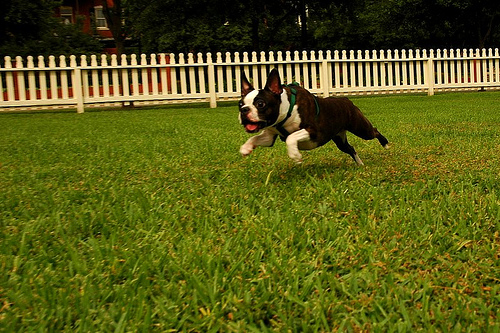

dog is running through the grass


In [73]:
make_prediction('/content/sample_image1.png')

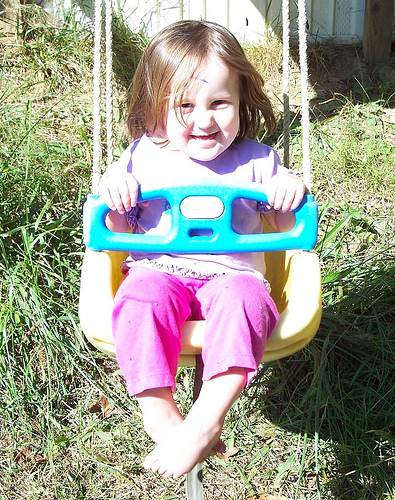

little boy in pink dress is swinging on swing


In [75]:
make_prediction('/content/sample_image2.png')

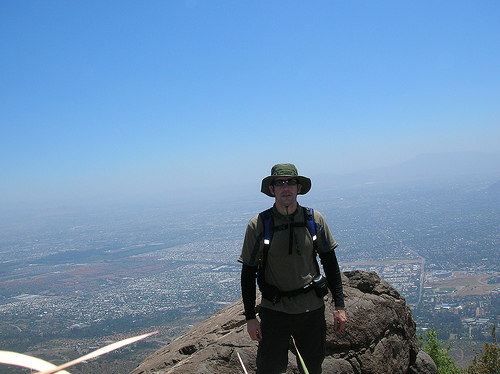

man in black shirt is standing on rock overlooking the water


In [76]:
make_prediction('/content/sample_image3.png')